In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import typing

from IPython.display import display, Markdown

from collections import defaultdict
import numpy as np
import pandas as pd
from pandas.core.groupby import SeriesGroupBy  # type: ignore
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.axes
import matplotlib.patches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec

from simple_relational_reasoning.embeddings.visualizations import DEFAULT_COLORMAP, DEFAULT_BAR_KWARGS, DEFAULT_TEXT_KWARGS, DEFAULT_YLIM, plot_prettify, filter_and_group, save_plot  # type: ignore


In [14]:
USE_LARGER_RESUTLS = False

LARGER_FILES = SMALLER_FILES = [
    'quinn_above_below_improved.csv', 
    'quinn_above_below_improved_habituation_shuffle.csv',
    'quinn_between_improved.csv',
    'quinn_between_improved_habituation_shuffle.csv',
]


CORRECT_KEY = 'habituation_same_cos'
INCORRECT_KEYS = ['habituation_different_cos']
ORDERED_COLUMNS = [
    'full_model_name', 'model', 'training', 'flip', 'dino', 
    'configuration_index', 'example_index', 
    'relation', 'reference_object', 'target_object', 
    'habituation_target_object', 'n_target_types',
    'same_vs_different', 'same_vs_different_diff', 'same_vs_different_ratio', 
    'different_similar', 'same_similar'
]
TARGET_OBJECTS = ['BeachBall', 'Knight', 'Lego', 'Pineapple', 'PingPong', 'Robot', 'RubberDuck', 'Teddy',]

ABOVE_BELOW_RELATION = 'above_below'
BETWEEN_RELATION = 'between'


def load_and_join_dataframes(folder: str, files: typing.Sequence[str]) -> pd.DataFrame:
    dfs = []
    for file_name in files:
        df = pd.read_csv(os.path.join(folder, file_name))
        df = df.assign(relation=ABOVE_BELOW_RELATION if 'above_below' in file_name else BETWEEN_RELATION)
        if 'habituation_target_object' not in df.columns:
            df = df.assign(habituation_target_object=df.target_object)
        dfs.append(df)

    df = pd.concat(dfs)
    df.reset_index(drop=True, inplace=True)
    return df

def load_df(folder: str, file: str,) -> pd.DataFrame:
    return pd.read_csv(os.path.join(folder, file))

def parse_model_name(df: pd.DataFrame) -> pd.DataFrame:
    new_series_values = defaultdict(list)

    for name in df.model:
        split_index = name.index('-')
        base_model, training_type = name[:split_index], name[split_index + 1:]

        flip = None
        dino = None

        if 'DINO' in training_type:
            training_type, dino = training_type.split('-')
            if dino == 'S':
                dino = 'saycam(S)'

        if '-' in training_type:
            training_type, flip = training_type.split('-')
            training_type += '-flip'

        if training_type == 'imagenet':
            training_type = 'ImageNet'

        new_series_values['full_model_name'].append(name)  # type: ignore
        new_series_values['model'].append(base_model)
        new_series_values['training'].append(training_type)
        new_series_values['flip'].append(flip)
        new_series_values['dino'].append(dino)

    return df.assign(**new_series_values)


def _key_middle(key: str, sep: str ='_') -> str:
    return sep.join(key.split(sep)[1:-1])


def _key_to_similarity_key(key: str) -> str:
    return f'{_key_middle(key)}_similar'


def pairwise_correct_key(correct_key: str, incorrect_key: str, suffix: str = '') -> str:
    return f'{_key_middle(correct_key)}_vs_{_key_middle(incorrect_key)}{suffix}'


def evaluate_accuracy(df: pd.DataFrame, correct_key: str = CORRECT_KEY, 
    incorrect_keys: typing.Sequence[str] = INCORRECT_KEYS) -> pd.DataFrame:
    max_similarities = {_key_to_similarity_key(key): [] for key in incorrect_keys}
    max_similarities[_key_to_similarity_key(correct_key)] = []

    pairwise_comparisons = {pairwise_correct_key(correct_key, key, suffix): [] for key in incorrect_keys
        for suffix in ('', '_diff', '_ratio')}

    for _, row in df.iterrows():    
        row = row[[correct_key] + list(incorrect_keys)]
        max_value = row.max()

        correct_val = row[correct_key]
        max_similarities[_key_to_similarity_key(correct_key)].append(correct_val == max_value)
        
        for incorrect_key in incorrect_keys:
            incorrect_val = row[incorrect_key]
            max_similarities[_key_to_similarity_key(incorrect_key)].append(incorrect_val == max_value)

            pairwise_comparisons[pairwise_correct_key(correct_key, incorrect_key)].append(correct_val >= incorrect_val)
            pairwise_comparisons[pairwise_correct_key(correct_key, incorrect_key, '_diff')].append(correct_val - incorrect_val)
            pairwise_comparisons[pairwise_correct_key(correct_key, incorrect_key, '_ratio')].append(correct_val / incorrect_val)

    return df.assign(**pairwise_comparisons, **max_similarities)


def full_load_pipeline(folder: str, files: typing.Sequence[str], ignore_list: typing.Sequence[str] = tuple()):
    df = load_and_join_dataframes(folder, files)
    # df = load_df(folder, file)
    df.drop(columns=[df.columns[0]], inplace=True)  # type: ignore
    df = parse_model_name(df)
    # df = add_target_object_field(df)
    df = evaluate_accuracy(df)
    df = df.assign(n_target_types=np.where(df.target_object == df.habituation_target_object, 1, 2))
    df = df[ORDERED_COLUMNS]
    return df


larger_df = full_load_pipeline('../containment_support_outputs', SMALLER_FILES)  #  ignore_list=IGNORE_SMALLER_LIST)
smaller_df = full_load_pipeline('../containment_support_outputs', LARGER_FILES)  # ignore_list=IGNORE_LARGER_LIST)
print(larger_df.shape, smaller_df.shape)

if USE_LARGER_RESUTLS:
    combined_df = larger_df
else:
    combined_df = smaller_df


print(combined_df.shape)
combined_df.head()

(98304, 17) (98304, 17)
(98304, 17)


,full_model_name,model,training,flip,dino,configuration_index,example_index,relation,reference_object,target_object,habituation_target_object,n_target_types,same_vs_different,same_vs_different_diff,same_vs_different_ratio,different_similar,same_similar
0,mobilenet-saycam(S),mobilenet,saycam(S),None,None,0,0,above_below,Table,BeachBall,BeachBall,1,True,0.069119,1.076779,False,True
1,mobilenet-saycam(S),mobilenet,saycam(S),None,None,0,1,above_below,Table,Knight,Knight,1,True,0.037630,1.039899,False,True
2,mobilenet-saycam(S),mobilenet,saycam(S),None,None,0,2,above_below,Table,Lego,Lego,1,True,0.021273,1.022025,False,True
3,mobilenet-saycam(S),mobilenet,saycam(S),None,None,0,3,above_below,Table,Pineapple,Pineapple,1,True,0.060576,1.066648,False,True
4,mobilenet-saycam(S),mobilenet,saycam(S),None,None,0,4,above_below,Table,PingPong,PingPong,1,True,0.045205,1.048592,False,True


In [15]:
combined_df.to_csv('../containment_support_outputs/dataframes/quinn_relations_df.csv', index=False)

In [20]:
DEFAULT_ORDERS = {
    'model_name': ['mobilenet', 'resnext'],
    'training': ['saycam(S)', 'ImageNet', 'random'],
    'above_below_type': ['one_reference', 'adjacent_references', 'gapped_references'],
    'flip': ['s', 'h', 'v', 'hv'],
    'triplet_generator': ['diagonal', 'equidistant'],
    'same_horizontal_half': [True, False],
    'condition': ['different_shapes', 'split_text', 'random_color'],
}

# nested dict, where the first key is the style (name, hatch, etc,)
# the second key is the field name (model name, relation, etc)
# the third key is the field value (resnext, mobilenet, etc.)
# and the value is the value for that style keyword
DEFAULT_PLOT_STYLES = dict(
    color=dict(
        # if we color by model
        model={
            'mobilenet': DEFAULT_COLORMAP(0),
            'resnext': DEFAULT_COLORMAP(1),
        },
        # if we color by dino
        dino={
            'ImageNet': DEFAULT_COLORMAP(2), 
            'saycam(S)': DEFAULT_COLORMAP(3),
        },
        # if we color by flip
        flip={
            's': DEFAULT_COLORMAP(4),
            'h': DEFAULT_COLORMAP(5),
            'v': DEFAULT_COLORMAP(6),
            'hv': DEFAULT_COLORMAP(7),
        }
    ),
    hatch=dict(
        n_target_types={
            1: '',
            2: '/',
        },
        n_habituation_stimuli={
            1: '',
            4: '+',
        }
    )
)

DEFAULT_SUBPLOT_ADJUST_PARAMS = dict(top=0.8)

DEFAULT_LINE_KWARGS = dict(marker='.', linestyle='-')

DEFAULT_YALBELS = defaultdict(lambda: 'Accuracy', 
    cos_ratio='Cosine similarity ratio',
    cos_diff='Cosine similarity difference',
)


def plot_single_bar(
    ax: matplotlib.axes.Axes,
    x: float,
    key: typing.Sequence[str],
    mean: pd.core.groupby.SeriesGroupBy,  # type: ignore
    std: pd.core.groupby.SeriesGroupBy,   # type: ignore
    plot_std: bool,
    bar_width: float, 
    bar_kwargs: typing.Dict[str, typing.Any],
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]],
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
):

    key = tuple(key)
    m = mean.loc[key]

    if remap_range is not None:
        m = m * (remap_range[1] - remap_range[0]) + remap_range[0]

    if plot_std:
        s = std.loc[key]
    else:
        s = None

    ax.bar(x, m, yerr=s, width=bar_width, **bar_kwargs, **global_bar_kwargs) 
    # TODO: above bar texts would go here, if they exist
    return x + bar_width 


def plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    hatch_bars_by: typing.Optional[str] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Union[str, int]] = DEFAULT_BAR_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):
    x = 0

    for group_by_value in orders_by_field[group_bars_by]:
        for color_by_value in orders_by_field[color_bars_by]:
            bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])

            group_and_color_key = [group_by_value, color_by_value]

            if hatch_bars_by is not None:
                for hatch_by_value in orders_by_field[hatch_bars_by]:
                    bar_kwargs['hatch'] = plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value]

                    hatch_key = group_and_color_key[:]
                    hatch_key.append(hatch_by_value)

                    x = plot_single_bar(ax, x, hatch_key, mean, std, 
                        plot_std, bar_width, 
                        bar_kwargs, global_bar_kwargs,
                        remap_range=remap_range)
            
            else:
                x = plot_single_bar(ax, x, group_and_color_key, mean, std, 
                    plot_std, bar_width, 
                    bar_kwargs, global_bar_kwargs,
                    remap_range=remap_range)

        x += bar_group_spacing

    group_values = orders_by_field[group_bars_by]

    group_length = len(orders_by_field[color_bars_by]) * (len(orders_by_field[hatch_bars_by]) if hatch_bars_by is not None else 1)
    x_tick_locations = np.arange(len(group_values)) * (bar_group_spacing + bar_width * group_length) +\
                        bar_width * (group_length / 2 - 0.5)
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_tick_locations)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def line_plot_single_panel(
    ax: matplotlib.axes.Axes,
    mean: SeriesGroupBy,
    std: SeriesGroupBy,
    plot_std: bool,
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    group_bars_by: str, 
    color_bars_by: str, 
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: str = 'Accuracy', 
):

    group_values = orders_by_field[group_bars_by]    
    x_locs = np.arange(len(group_values))
    for color_by_value in orders_by_field[color_bars_by]:
        means = [mean.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]
        stds = [std.loc[tuple([group_by_value, color_by_value])] for group_by_value in group_values]

        if remap_range is not None:
            means = [m * (remap_range[1] - remap_range[0]) + remap_range[0] for m in means]

        if plot_std:
            ax.errorbar(x_locs, means, stds, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
        else:
            ax.plot(x_locs, means, color=plot_style_by_field['color'][color_bars_by][color_by_value],
                **global_line_kwargs)
    
    xtick_text_kwargs = text_kwargs.copy()
    if len(group_values) > 4:
        xtick_text_kwargs['fontsize'] -= 4
    ax.set_xticks(x_locs)
    ax.set_xticklabels([plot_prettify(val, field_name=group_bars_by) for val in group_values], fontdict=xtick_text_kwargs)
    ax.tick_params(axis='both', which='major', labelsize=text_kwargs['fontsize'] - 4)

    if add_chance_hline:
        xlim = ax.get_xlim()
        if remap_range is not None:
            y_chance = (remap_range[1] - remap_range[0]) * y_chance + remap_range[0]
        ax.hlines(y_chance, *xlim, linestyle='--', alpha=0.5, color='black')
        ax.set_xlim(*xlim)
        
    if ylim is not None:
        if remap_range is not None:
            ylim = (ylim[0] * (remap_range[1] - remap_range[0]) + remap_range[0], ylim[1] * (remap_range[1] - remap_range[0]) + remap_range[0])
        ax.set_ylim(*ylim)

    ax.set_xlabel(plot_prettify(group_bars_by), **text_kwargs)
    _add_ylabel_to_ax(ax, ylabel, text_kwargs)


def _add_ylabel_to_ax(ax: matplotlib.axes.Axes, ylabel: typing.Union[str, typing.Sequence[typing.Dict[str, typing.Any]]], 
    text_kwargs: typing.Dict[str, typing.Any]):

    if isinstance(ylabel, str):
        ax.set_ylabel(ylabel, **text_kwargs)

    elif isinstance(ylabel, (list, tuple)):
        multiple_label_kwargs = copy.copy(text_kwargs)
        multiple_label_kwargs['fontsize'] -= 4

        for ylabel_part in ylabel:
            ax.text(**ylabel_part, transform=ax.transAxes, **multiple_label_kwargs)

    else:
        print(f'Unrecognized ylabel: {ylabel}')


def add_legend_to_ax(ax: matplotlib.axes.Axes, 
    orders_by_field: typing.Dict[str, typing.List[str]],
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]],
    color_bars_by: str,
    hatch_bars_by: typing.Optional[str] = None,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    legend_loc: typing.Optional[str] = 'best', 
    legend_ncol: typing.Optional[int] = None,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None):

    patches = []

    if legend_ncol is None:
        legend_ncol = 1

    if legend_kwargs is None:
        legend_kwargs = {}

    for color_by_value in orders_by_field[color_bars_by]:
        bar_kwargs = dict(facecolor=plot_style_by_field['color'][color_bars_by][color_by_value])
        patch_kwargs = dict(facecolor='none', edgecolor='black')
        patch_kwargs.update(bar_kwargs)
        patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(color_by_value, color_bars_by)))
    
    if hatch_bars_by is not None:
        for hatch_by_value in orders_by_field[hatch_bars_by]:
            bar_kwargs=dict(hatch=plot_style_by_field['hatch'][hatch_bars_by][hatch_by_value])
            patch_kwargs = dict(facecolor='none', edgecolor='black')
            patch_kwargs.update(bar_kwargs)
            patches.append(matplotlib.patches.Patch(**patch_kwargs, label=plot_prettify(hatch_by_value, hatch_bars_by)))

    if 'fontsize' not in legend_kwargs:
        legend_kwargs['fontsize'] = text_kwargs['fontsize'] - 4

    if len(patches) > 0: 
        ax.legend(handles=patches, loc=legend_loc, ncol=legend_ncol, **legend_kwargs)
    

def multiple_bar_plots(df: pd.DataFrame, *,
    # what and how to plot arguments
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Union[None, str, typing.Sequence[str]] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    plot_field: str = 'same_similar',
    compute_std: bool = False,
    plot_std: bool = True,
    sem: bool = True,
    remap_range: typing.Optional[typing.Tuple[float, float]] = None,
    orders_by_field: typing.Dict[str, typing.List[str]] = DEFAULT_ORDERS,
    # plot style arguments
    plot_style_by_field: typing.Dict[str, typing.Dict[str, typing.Dict[str, typing.Any]]] = DEFAULT_PLOT_STYLES, # type: ignore
    ax: typing.Union[matplotlib.axes.Axes, typing.Sequence[matplotlib.axes.Axes], None] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    layout: typing.Optional[typing.Tuple[int, int]] = None,
    bar_width: float = 0.2, 
    bar_group_spacing: float = 0.5, 
    add_chance_hline: bool = True,
    y_chance: float = 0.5,
    global_bar_kwargs: typing.Dict[str, typing.Any] = DEFAULT_BAR_KWARGS,
    global_line_kwargs: typing.Dict[str, typing.Any] = DEFAULT_LINE_KWARGS,
    text_kwargs: typing.Dict[str, typing.Any] = DEFAULT_TEXT_KWARGS,
    title_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    ylim: typing.Tuple[float, float] = DEFAULT_YLIM,
    ylabel: typing.Union[None, str, typing.List[str]] = None,
    ylabel_per_ax: bool = False,
    legend_ax_index: typing.Optional[int] = None, 
    legend_loc: typing.Optional[str] ='best', 
    legend_ncol: typing.Optional[int] = None,
    panel_titles: typing.Union[str, typing.Sequence[str], None] = None,
    sup_title: typing.Optional[str] = None,
    subplot_adjust_params: typing.Dict[str, typing.Any] = DEFAULT_SUBPLOT_ADJUST_PARAMS,
    legend_kwargs: typing.Optional[typing.Dict[str, typing.Any]] = None,
    line_plot: bool = False,
    # plot saving arguments
    save_path: typing.Optional[str] = None, 
    save_should_print: bool = False, 
    ):

    if global_bar_kwargs is None:
        global_bar_kwargs = dict()

    if global_line_kwargs is None:
        global_line_kwargs = dict()

    if title_kwargs is None:
        title_kwargs = {}
    if 'fontsize' not in title_kwargs:
        title_kwargs['fontsize'] = text_kwargs['fontsize'] + 8

    group_by_fields = [group_bars_by, color_bars_by]

    # if panel_by is a list, it's a series of metrics to panel_by
    if panel_by is not None and isinstance(panel_by, str):
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    if line_plot and hatch_bars_by is not None:
        raise ValueError(f'Cannot plot line plot with hatch bars by, received: {hatch_bars_by}')

    if ylabel is None:
        ylabel = DEFAULT_YALBELS[plot_field]

    if ylabel_per_ax:
        if panel_by is None:
            raise ValueError(f'Must provide panel_by (received {panel_by}) if ylabel_per_ax is True')

        if len(ylabel) != np.product(layout):
            raise ValueError(f'Must provide ylabel with length equal to product of layout (received {layout}) if ylabel_per_ax is True')

    grouped_df = filter_and_group(df, filter_dict, group_by_fields)

    if panel_by is not None and not isinstance(panel_by, str):
        panel_by_values = []
        for metric in panel_by:
            mean = grouped_df[metric].mean()
            std = grouped_df[plot_field].std()
            if sem:
                std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore

            panel_by_values.append((mean, std))

        mean = panel_by_values[0][0]
    
    else:
        mean = grouped_df[plot_field].mean()

        if compute_std:
            std = grouped_df[plot_field].std()
            if sem:
                std /= np.sqrt(grouped_df[plot_field].count())  # type: ignore
        
        else:
            if sem:
                std = grouped_df.acc_sem.mean()
            else:
                std = grouped_df.acc_std.mean()

    orders_by_field = copy.deepcopy(orders_by_field)
    for field in group_by_fields:
        field_values = list(sorted(mean.index.unique(level=field))) 
        if field not in orders_by_field:
            orders_by_field[field] = field_values

        else:
            for order_value in orders_by_field[field]:
                if order_value not in field_values:
                    orders_by_field[field].remove(order_value)

    fig = None
    if ax is None:
        if panel_by is None:
            fig, ax = plt.subplots(1, 1, figsize=figsize)

        else:
            if layout is None:
                raise ValueError('layout must be specified if panel_by is specified')

            if isinstance(panel_by, str) and np.prod(layout) != len(orders_by_field[panel_by]):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')
            
            if not isinstance(panel_by, str) and np.prod(layout) != len(panel_by):
                raise ValueError('layout must have the same number of cells as the number of unique values of panel_by')

            fig, ax = plt.subplots(*layout, figsize=figsize)

    if panel_by is None:
        if line_plot:
            line_plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, 
                remap_range, add_chance_hline, y_chance,
                global_line_kwargs, text_kwargs, 
                ylim, ylabel)

        else:
            plot_single_panel(ax, mean, std,  # type: ignore
                plot_std, orders_by_field, plot_style_by_field,
                group_bars_by, color_bars_by, hatch_bars_by,
                bar_width, bar_group_spacing, 
                remap_range, add_chance_hline, y_chance,
                global_bar_kwargs, text_kwargs, 
                ylim, ylabel)

        add_legend_to_ax(ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by,  # type: ignore
            text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

        if panel_titles is not None:
            if isinstance(panel_titles, list):
                if len(panel_titles) > 1:
                    raise ValueError(f'When plotting a single panel, must receive no more than one title, received: {panel_titles}')

                panel_titles = panel_titles[0]

            ax.set_title(panel_titles, **title_kwargs)  # type: ignore

    else:
        n_rows, n_cols = layout  # type: ignore
        if panel_titles is not None:
            if not hasattr(panel_titles, '__len__'):
                raise ValueError(f'When plotting multiple panels, must receive a sequence of panel titles')

            if len(panel_titles) != n_rows * n_cols:
                raise ValueError(f'When plotting multiple panels, must receive a title for each panel, received: {panel_titles}')

        if isinstance(panel_by, str):
            panel_iter = [(mean[panel_value], std[panel_value], plot_prettify(panel_value, panel_by)) for panel_value in orders_by_field[panel_by]]  # type: ignore

        else:
            panel_iter = [(*panel_by_values[i], f'Plotting {panel_metric}') for i, panel_metric in enumerate(panel_by)]  # type: ignore


        for i, (panel_mean, panel_std, panel_title) in enumerate(panel_iter):
            panel_ax = ax[i]  # type: ignore

            ax_ylabel = ylabel if not ylabel_per_ax else ylabel[i]

            if line_plot:
                line_plot_single_panel(panel_ax, panel_mean, panel_std,
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, 
                    remap_range, add_chance_hline, y_chance,
                    global_line_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_cols == 0 else '')

            else:
                plot_single_panel(panel_ax, panel_mean, panel_std, 
                    plot_std, orders_by_field, plot_style_by_field,
                    group_bars_by, color_bars_by, hatch_bars_by,
                    bar_width, bar_group_spacing, 
                    remap_range, add_chance_hline, y_chance,
                    global_bar_kwargs, text_kwargs, 
                    ylim, ax_ylabel if i % n_cols == 0 else '')

            if i == legend_ax_index:
                add_legend_to_ax(panel_ax, orders_by_field, plot_style_by_field, color_bars_by, hatch_bars_by, 
                    text_kwargs, legend_loc, legend_ncol, legend_kwargs=legend_kwargs)

            if panel_titles is not None:
                panel_title = panel_titles[i]
                
            panel_ax.set_title(panel_title, **title_kwargs)

    if sup_title is not None:
        plt.suptitle(sup_title, **title_kwargs)
        if fig is not None: fig.subplots_adjust(**subplot_adjust_params)

    # TODO: consider if we want to do the above-bar text things again
    if save_path is not None:
        save_plot(save_path, should_print=save_should_print)
    
    plt.show()

In [21]:
DEFAULT_RELEVANT_FIELDS = (CORRECT_KEY, *INCORRECT_KEYS, 'correct', 'cos_ratio')

def compare_df_group_and_filter(first_df: pd.DataFrame, second_df: pd.DataFrame,
    filter_dict: typing.Dict[str, typing.Union[str, None, typing.Sequence[str]]],
    group_bars_by: str, 
    color_bars_by: str, 
    panel_by: typing.Optional[str] = None, 
    hatch_bars_by: typing.Optional[str] = None,
    relevant_fields: typing.Sequence[str] = DEFAULT_RELEVANT_FIELDS,
):
    group_by_fields = [group_bars_by, color_bars_by]
    if panel_by is not None:
        group_by_fields.insert(0, panel_by)
    if hatch_bars_by is not None:
        group_by_fields.append(hatch_bars_by)

    relevant_fields = list(relevant_fields)

    first_grouped_df = filter_and_group(first_df, filter_dict, group_by_fields)
    first_mean = first_grouped_df.mean()

    display(Markdown('## First dataframe'))
    display(Markdown('### Mean:'))
    display(first_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(first_grouped_df.std()[relevant_fields])

    second_grouped_df = filter_and_group(second_df, filter_dict, group_by_fields)
    second_mean = second_grouped_df.mean()

    display(Markdown('## Second dataframe'))
    display(Markdown('### Mean:'))
    display(second_mean[relevant_fields])
    display(Markdown('### Std:'))
    display(second_grouped_df.std()[relevant_fields])
    
    return first_mean[relevant_fields] - second_mean[relevant_fields]

    

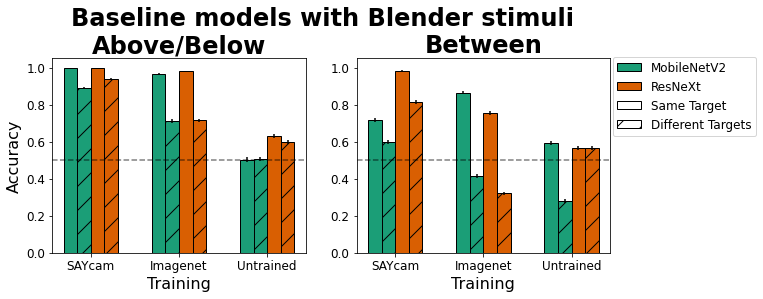

In [45]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (10, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title='Baseline models with Blender stimuli',
    legend_ax_index=1,
    legend_loc='upper right',
    legend_kwargs=dict(bbox_to_anchor=(1.6, 1.04)),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

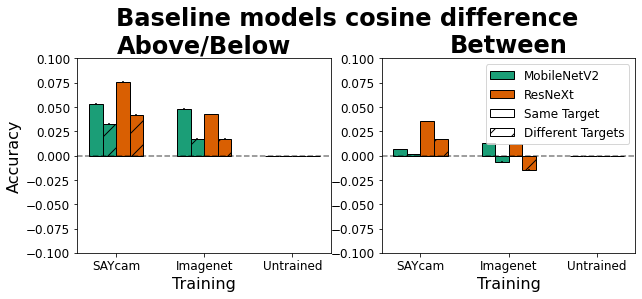

In [25]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training=['random', 'ImageNet', 'saycam(S)'], flip=None, dino=None),
    group_bars_by='training', 
    color_bars_by='model', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    plot_field='same_vs_different_diff',
    compute_std=True,
    # plot style arguments
    figsize = (10, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # panel_titles=f'Baseline models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title='Baseline models cosine difference',
    legend_ax_index=1,
    legend_loc='upper right',
    ylim=(-0.1, 0.1),
    y_chance=0,
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )
    

   

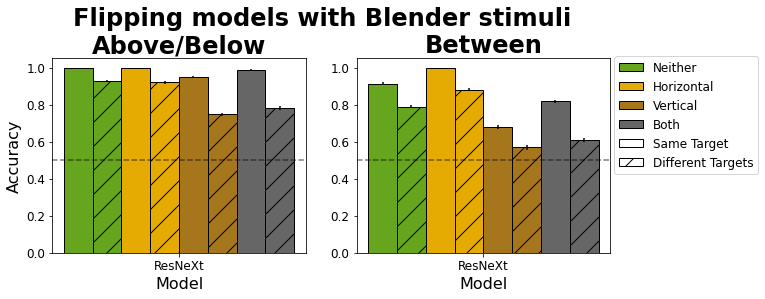

In [46]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='model', 
    color_bars_by='flip', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (10, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # panel_titles=f'Flipping models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title='Flipping models with Blender stimuli',
    legend_ax_index=1,
    legend_loc='lower center',
    legend_kwargs=dict(bbox_to_anchor=(1.3, .375)),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

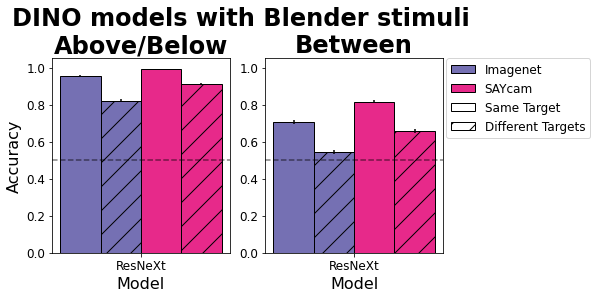

In [55]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='model', 
    color_bars_by='dino', 
    panel_by='relation',
    hatch_bars_by='n_target_types',
    # plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (7, 4),
    layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    panel_titles=['Above/Below', 'Between'],
    # panel_titles=f'DINO models{" (larger)" if USE_LARGER_RESUTLS else ""}',
    sup_title='DINO models with Blender stimuli',
    legend_ax_index=1,
    legend_loc='lower center',
    legend_kwargs=dict(bbox_to_anchor=(1.425, .56)),
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

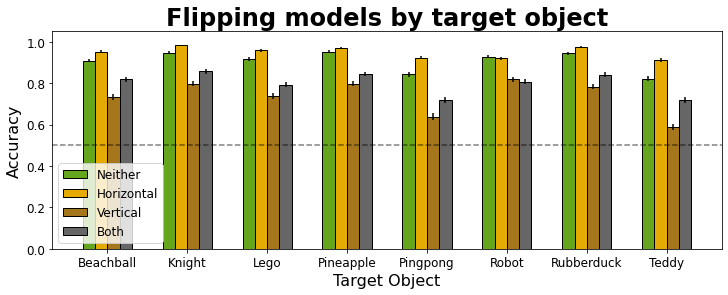

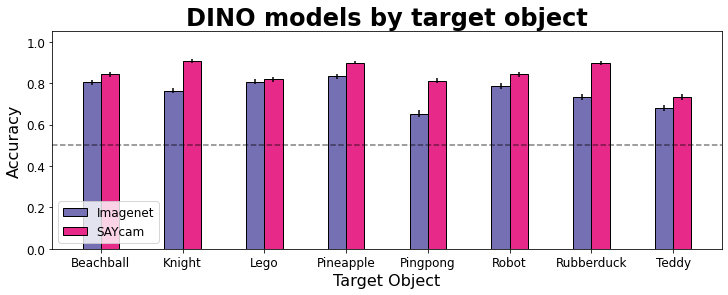

In [57]:
multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='saycam(S)-flip'),
    group_bars_by='target_object', 
    color_bars_by='flip', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    # plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'Flipping models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='lower left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )

multiple_bar_plots(combined_df,
    # what and how to plot arguments
    filter_dict=dict(training='DINO'),
    group_bars_by='target_object', 
    color_bars_by='dino', 
    # panel_by='relation',
    # hatch_bars_by='n_target_types',
    # plot_field='correct',
    compute_std=True,
    # plot style arguments
    figsize = (12, 4),
    # layout = (1, 2),
    title_kwargs=dict(fontweight='bold'),
    # panel_titles=['Above/Below', 'Between'],
    panel_titles=f'DINO models by target object{" (larger)" if USE_LARGER_RESUTLS else ""}',
    # sup_title='Baseline containment/support',
    legend_ax_index=1,
    legend_loc='lower left',
    # save_path='baseline_horizontal_references.png',
    # plot saving arguments
    # save_path: typing.Optional[str] = None, 
    # save_should_print: bool = False, 
    )